In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime
#from google.colab import drive
import json
import io
import glob
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
#!pip install census
#!pip install us
#!pip install xgboost
from xgboost import XGBRegressor
from census import Census
from us import states

#drive.mount('/content/drive')

random_state = 1701

Because the scraped data set was limited in features, I chose to supplement it with census data (2023 ACS 5-year estimates) at the ZIP code level. The variables included for each ZIP code were:

*   Travel time to work
*   Vacant housing units
*   Total population
*   Median household income
*   Median age

To fill in missing data values for building age, median building age was also obtained from the ACS data.

In [5]:
c = Census("aa512886c5449a582d837da8d3a07af66a043fe5")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 9000)
census_vars = {'B08303': 'Travel Time to Work',
               'B25004_001E':	'Vacant housing units for rent',
               'B01003_001E':	'Total Population',
               'B19013_001E':	'Median Household Income in the Past 12 Months (in 2023 Inflation-Adjusted Dollars)',
               'B25035_001E':	'Median Year Structure Built',
               'B01002_001E': 'Median Age'}
census_data = pd.DataFrame(c.acs5.get(['B08303_002E','B08303_003E', 'B08303_004E', 'B08303_005E', 'B08303_006E', 'B08303_007E', 'B08303_008E', 'B08303_009E', 'B08303_010E', 'B08303_011E', 'B08303_012E',
                         'B08303_013E', 'B25004_001E', 'B01003_001E', 'B19013_001E', 'B25035_001E', 'B01002_001E'], {'for':'zip code tabulation area:*'}))
census_data.rename({'B25004_001E': 'area_vacancies', 'B01003_001E': 'area_pop', 'B19013_001E': 'med_income', 'B25035_001E': 'med_yearbuilt', 'B01002_001E': 'med_age'}, axis=1, inplace=True)

boroughs = pd.read_csv("data/Boroughs.csv", dtype={'zip':object})
census_data = pd.merge(census_data, boroughs, right_on='zip', left_on='zip code tabulation area')

Commute time was a survey question with ranges as options, so I used the midpoint of each time range to calculate average commute time:
* Less than 5 minutes -> 2
* 5 to 9 minutes -> 7
* 10 to 14 minutes -> 12
* 15 to 19 minutes -> 17
* 20 to 24 minutes -> 22
* 25 to 29 minutes -> 27
* 30 to 34 minutes -> 32
* 35 to 39 minutes -> 37
* 40 to 44 minutes -> 42
* 45 to 59 minutes -> 52
* 60 to 89 minutes -> 74.5
* 90 or more minutes -> estimate as 100

In [6]:
census_data['avg_commute'] = (2*census_data['B08303_002E'] + 7*census_data['B08303_003E'] + 12*census_data['B08303_004E'] + 17*census_data['B08303_005E'] +
                              22*census_data['B08303_006E'] + 27*census_data['B08303_007E'] + 32*census_data['B08303_008E'] + 37*census_data['B08303_009E'] +
                              42*census_data['B08303_010E'] + 52*census_data['B08303_011E'] + 74.5*census_data['B08303_012E'] + 100*census_data['B08303_013E']) / census_data.loc[:,'B08303_002E':'B08303_013E'].sum(axis=1)
census_data = census_data.drop(list(census_data.filter(regex='B08303')), axis=1)

Import the data and combine all files. Merge with census data based on ZIP code.

The scraped data listed full baths and half-baths separately, combine these into one variable counting a half-bath as 0.5. It also listed some properties with a price range rather than a single list price; for these I took the center of the listed range as the price to be predicted.

There were a few outliers which threw off estimates, so I chose to remove them from the dataset (properties with more than 10 bathrooms or listed for a rent of $1,000,000+ per month -- these are likely retail or office spaces misidentified by the scraper.)

I also tried creating some features based on whether certain words were mentioned in the description, but found that they had only a very small impact on model performance (perhaps they are collinear with some combination of existing features), so I chose to omit them from the final model.

In [11]:
rents = pd.DataFrame()

for f in glob.glob("data" + "/HomeHarvest*.csv"):
  data = pd.read_csv(f)
  if(len(rents) == 0):
    rents = data
  else:
    rents = pd.concat([rents, data], axis=0)
print(rents.shape)
rents = rents[rents['status'] == "FOR_RENT"].dropna(subset=['beds', 'zip_code', 'sqft'])
rents['zip_code'] = rents['zip_code'].astype('string').str.split(".").str.get(0)
rents = pd.merge(rents, census_data, left_on='zip_code', right_on='zip code tabulation area')
rents.fillna({'full_baths': 0, 'half_baths': 0, 'year_built': rents['med_yearbuilt'].astype(int), 'list_price': (rents['list_price_max']-rents['list_price_min'])/2,
              'parking_garage': 0}, inplace=True)
rents['baths'] = rents['full_baths'] + 0.5*rents['half_baths']
rents = rents[(rents['baths'] < 10) & (rents['list_price'] < 1000000)]
rents['building_age'] = 2025 - rents['year_built']
rents['penthouse'] = rents['text'].str.lower().str.contains('penthouse', na=False)
rents['doorman'] = rents['text'].str.lower().str.contains('concierge|doorman', regex=True, na=False)
rents['fitness'] = rents['text'].str.lower().str.contains('fitness center|fitness room', regex=True, na=False)

print(rents.shape)
rents.dropna(subset=['list_price'], inplace=True)
rents.drop_duplicates(subset=['property_id'], inplace=True)

(15121, 59)
(4196, 73)


Final selected features. In this notebook I do the dummy-coding and scaling separately, in the Streamlit code I used a pipeline so the app could handle user input appropriately.

In [12]:
rents_processed = rents.copy()
rents_processed = rents_processed[['list_price', 'beds', 'baths', 'building_age', 'borough', 'area_vacancies', 'area_pop',	'med_income',	'avg_commute', 'sqft', 'style', 'med_age']]
rents_processed = pd.get_dummies(rents_processed, columns=['borough', 'style'], drop_first=True)
numeric_columns = ['beds', 'baths', 'building_age', 'area_vacancies', 'area_pop',	'med_income',	'avg_commute', 'sqft', 'med_age']
categorical_columns = list(set(rents_processed.columns) - set(numeric_columns) - set(['list_price']))
rents_processed

,list_price,beds,baths,building_age,area_vacancies,area_pop,med_income,avg_commute,sqft,med_age,borough_Brooklyn,borough_Manhattan,borough_Queens,borough_Staten Island,style_CONDOP,style_CONDOS,style_COOP,style_DUPLEX_TRIPLEX,style_MULTI_FAMILY,style_SINGLE_FAMILY,style_TOWNHOMES
0,2500.0,2.0,1.0,80.0,434.0,19638.0,107591.0,43.509659,745.0,46.4,False,False,True,False,False,False,False,False,False,False,False
1,4500.0,3.0,2.0,115.0,3529.0,65068.0,64220.0,34.395816,1200.0,32.5,False,True,False,False,False,False,False,False,False,True,False
2,2400.0,1.0,1.0,65.0,2721.0,93445.0,55419.0,50.221884,700.0,36.4,True,False,False,False,False,False,False,False,False,False,False
3,1350.0,1.0,1.0,51.0,770.0,29996.0,122654.0,53.453245,1981.0,43.2,False,False,False,True,False,False,False,False,False,False,False
4,2350.0,2.0,1.0,94.0,1027.0,69373.0,72952.0,49.528050,905.0,41.9,False,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4194,45000.0,4.0,3.5,152.0,3324.0,28215.0,159474.0,28.365969,4200.0,40.3,False,True,False,False,False,False,True,False,False,False,False
4195,19800.0,3.0,3.0,19.0,402.0,7802.0,250001.0,25.655182,1685.0,33.8,False,True,False,False,False,False,False,False,False,False,False
4197,77500.0,4.0,5.0,10.0,7059.0,34340.0,171038.0,28.818509,4462.0,47.1,False,True,False,False,False,False,False,False,False,False,False
4198,4950.0,1.0,2.0,87.0,2450.0,70922.0,180773.0,42.008712,900.0,37.4,True,False,False,False,False,False,False,False,False,False,False


The bedrooms, bathrooms, and square footage variables are all highly correlated with one another. Leaving them as separate variables in the models led to one of them (with my random seed, it was `baths`) being given high importance, and the others treated as irrelevant. This is fine for prediction on the test set (where the same correlations are preset), but unintuitive for an interactive app as it is easy for users to put in combinations of bedrooms, bathrooms, and square footage which are unlikely to occur in real life and be surprised that (for example) doubling the size of an apartment with two bathrooms supposedly has little impact on the price.

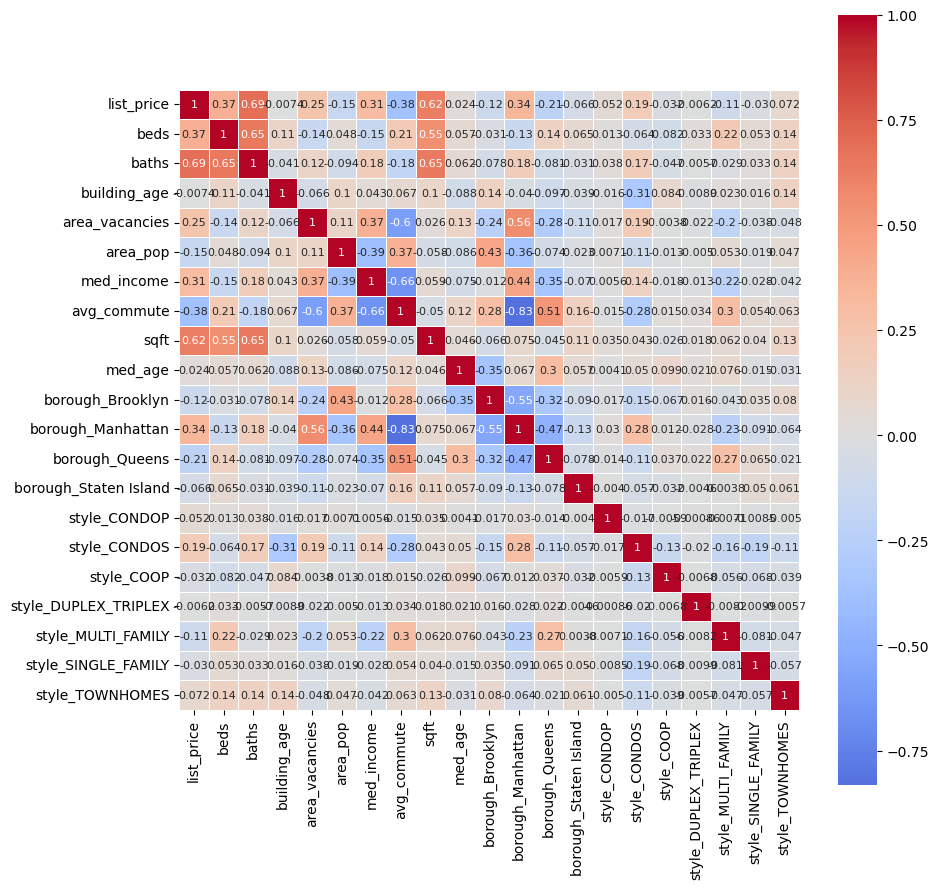

In [13]:
correlation_matrix = rents_processed.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, annot_kws={"fontsize":8})
plt.show()

Train-test split.

I chose to scale only the non-categorical variables, as the dummies were already on a 0-1 scale. To make sure this didn't impact the model performance, I also experimented with scaling dummies along with the other variables and found that the difference was insignificant.

I also chose to predict the log of the listing price, rather than the price itself (this is easy to convert into the actual price once a prediction is made by exponentiating). This is a common statistical technique for working with long-tailed data, which housing prices tend to be (and this dataset was no exception.)

In [14]:
X = rents_processed.drop('list_price', axis=1)
y = np.log(rents_processed['list_price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

scaler = StandardScaler()
X_train_scaled = pd.concat(
    [pd.DataFrame(scaler.fit_transform(X_train[numeric_columns]), columns=numeric_columns, index=X_train.index),
    X_train[categorical_columns]],
    axis=1
)
X_test_scaled = pd.concat(
    [pd.DataFrame(scaler.transform(X_test[numeric_columns]), columns=numeric_columns, index=X_test.index),
    X_test[categorical_columns]],
    axis=1
)

scaler = StandardScaler()
X_train_allscaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_allscaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

To deal with the near-collinearity of bedrooms, bathrooms, and square footage, I used PCA to reduce these three features to two (this captured around 90% of the total variance in the three variables). The first component is interpretable as overall size, as all three features contribute equally to it, and explains ~75% of the variance. The second component is interpretable as rooms other than bedrooms and bathrooms -- it is positively associated with square footage and negatively with bedrooms/bathrooms.

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

pca_size = PCA(n_components=2)
size = pca_size.fit_transform(X_train_scaled[['beds', 'baths', 'sqft']])
size_test = pca_size.transform(X_test_scaled[['beds', 'baths', 'sqft']])
print(pca_size.explained_variance_ratio_)
print(pca_size.components_)
#size_test
X_train_pcasize = pd.concat([X_train.drop(['beds', 'baths', 'sqft'], axis=1),pd.DataFrame(size,columns=['size_Overall', 'size_NonBedBath'], index=X_train.index)], axis=1)
X_test_pcasize = pd.concat([X_test.drop(['beds', 'baths', 'sqft'], axis=1),pd.DataFrame(size_test,columns=['size_Overall', 'size_NonBedBath'], index=X_test.index)], axis=1)
X_test_pcasize

[0.73479427 0.1547214 ]
[[ 0.5713015   0.59708642  0.56311847]
 [-0.65680153 -0.07883058  0.74993166]]


,building_age,area_vacancies,area_pop,med_income,avg_commute,med_age,borough_Brooklyn,borough_Manhattan,borough_Queens,borough_Staten Island,style_CONDOP,style_CONDOS,style_COOP,style_DUPLEX_TRIPLEX,style_MULTI_FAMILY,style_SINGLE_FAMILY,style_TOWNHOMES,size_A,size_B
1037,70.0,2424.0,99433.0,71470.0,46.821184,38.3,False,False,True,False,False,False,False,False,False,False,False,-1.660779,0.556505
3983,7.0,3014.0,69251.0,169285.0,33.966002,35.2,True,False,False,False,False,True,False,False,False,False,False,1.084515,0.069443
387,115.0,1736.0,78741.0,42107.0,48.855512,31.1,False,False,False,False,False,False,False,False,False,False,False,0.480834,-0.355328
2885,55.0,2457.0,29079.0,123393.0,28.597633,35.0,False,True,False,False,False,False,False,False,False,False,False,-1.073319,0.084214
408,100.0,374.0,27933.0,98232.0,49.025336,42.3,False,False,True,False,False,False,False,False,False,True,False,0.775420,-0.507620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2841,17.0,1284.0,39082.0,40556.0,41.341588,36.9,False,True,False,False,False,False,False,False,False,False,False,-1.038957,0.129976
1252,126.0,1350.0,71313.0,95916.0,44.476929,37.7,True,False,False,False,False,False,False,False,True,False,False,-0.317172,-0.163430
2133,8.0,397.0,12967.0,117402.0,50.434847,42.5,False,False,True,False,False,True,False,False,False,False,False,0.250758,-0.496303
3248,70.0,7059.0,34340.0,171038.0,28.818509,47.1,False,True,False,False,False,False,False,False,False,True,False,3.844046,5.709116


Model fitting. I tested a linear regression (as required by the project), lasso regression, ridge regression, Random Forests model, Gradient Boosting model, and XGBoost model. As model performance with default hyperparameters was adequate, I did not experiment with hyperparameter settings.

In [16]:
linear_model = LinearRegression()
linear_model.fit(X_train_pcasize, y_train)

# Make predictions
y_pred_train = linear_model.predict(X_train_pcasize)
y_pred_test = linear_model.predict(X_test_pcasize)

coefficients_df = pd.DataFrame({
    'Feature': X_train_pcasize.columns,
    'Coefficient': linear_model.coef_
})
coefficients_df['Abs_Coefficient'] = abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values('Abs_Coefficient', ascending=False)

coefficients_df.head(10)

,Feature,Coefficient,Abs_Coefficient
18,borough_Staten Island,-0.381389,0.381389
16,style_CONDOP,0.262456,0.262456
6,avg_commute,-0.247100,0.247100
1,baths,0.231988,0.231988
17,borough_Queens,-0.156983,0.156983
0,beds,0.145687,0.145687
19,style_MULTI_FAMILY,-0.141348,0.141348
7,sqft,0.089120,0.089120
5,med_income,0.077929,0.077929
10,style_COOP,-0.071080,0.071080


In [17]:
lasso_model = LassoCV(cv=5, random_state=random_state)
lasso_model.fit(X_train_pcasize, y_train)
y_pred_lasso_train = lasso_model.predict(X_train_pcasize)
y_pred_lasso_test = lasso_model.predict(X_test_pcasize)

In [18]:
ridge_model = RidgeCV()
ridge_model.fit(X_train_pcasize, y_train)
y_pred_ridge_train = ridge_model.predict(X_train_pcasize)
y_pred_ridge_test = ridge_model.predict(X_test_pcasize)

In [19]:
rf_model = RandomForestRegressor(random_state = random_state)
rf_model.fit(X_train_pcasize, y_train)
y_pred_rf_train = rf_model.predict(X_train_pcasize)
y_pred_rf_test = rf_model.predict(X_test_pcasize)

topfeatures = pd.Series(abs(rf_model.feature_importances_), index=X_train_pcasize.columns)
topfeatures.sort_values(ascending=False).head(10)

baths             0.456025
avg_commute       0.273982
sqft              0.152576
building_age      0.026322
med_income        0.025267
beds              0.020147
med_age           0.013921
area_vacancies    0.010871
area_pop          0.009219
style_CONDOS      0.002628
dtype: float64

In [20]:
gradientboosting_model = GradientBoostingRegressor()
gradientboosting_model.fit(X_train_pcasize, y_train)
y_pred_gb_train = gradientboosting_model.predict(X_train_pcasize)
y_pred_gb_test = gradientboosting_model.predict(X_test_pcasize)

In [25]:
xgboost_model = XGBRegressor()
xgboost_model.fit(X_train_pcasize, y_train)
y_pred_xgb_train = xgboost_model.predict(X_train_pcasize)
y_pred_xgb_test = xgboost_model.predict(X_test_pcasize)

topfeatures = pd.Series(xgboost_model.feature_importances_, index=X_train_pcasize.columns)
topfeatures.sort_values(ascending=False).head(10)

avg_commute              0.509091
size_A                   0.207031
med_income               0.047213
borough_Manhattan        0.037315
borough_Staten Island    0.035544
size_B                   0.022784
med_age                  0.021987
borough_Brooklyn         0.020164
borough_Queens           0.018234
style_SINGLE_FAMILY      0.011732
dtype: float32

Model evaluation using 5-fold and 10-fold cross-validation. I tested the models with and without the beds/baths/square footage feature reduction to verify performance. I did this for `X_train_allscaled` (StandardScaler applied to all variables, not only numeric variables) too.


In [22]:
def calculate_cv_metrics(X_train_scaled, y_train, model_dict):
  results = pd.DataFrame({'5-fold average R-squared':[], '10-fold average R-squared':[]})
  for m in model_dict:
    model = model_dict[m]
    cv_score_5fold = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring = 'r2')
    cv_score_10fold = cross_val_score(model, X_train_scaled, y_train, cv=10, scoring = 'r2')
    results.loc[m] = [np.mean(cv_score_5fold), np.mean(cv_score_10fold)]
  return results

# Training set performance
model_dict = {'Linear Regression':linear_model, 'Lasso Regression':lasso_model, 'Ridge Regression':ridge_model, 'Random Forest':rf_model, 'Gradient Boosting':gradientboosting_model, 'XGBoost':xgboost_model}
results = calculate_cv_metrics(X_train_scaled, y_train, model_dict)
print("Cross-validation performance:")
print(results)

Cross-validation performance:
                   5-fold average R-squared  10-fold average R-squared
Linear Regression                  0.789500                   0.790068
Lasso Regression                   0.789516                   0.790104
Ridge Regression                   0.789572                   0.790117
Random Forest                      0.875255                   0.878250
Gradient Boosting                  0.871344                   0.869255
XGBoost                            0.878242                   0.881835


In [23]:
results = calculate_cv_metrics(X_train_pcasize, y_train, model_dict)
print("Performance with PCA for beds, baths, size variables:")
print(results)

Performance with PCA for beds, baths, size variables:
                   5-fold average R-squared  10-fold average R-squared
Linear Regression                  0.785199                   0.786043
Lasso Regression                   0.288175                   0.287410
Ridge Regression                   0.785290                   0.786119
Random Forest                      0.863845                   0.868544
Gradient Boosting                  0.856838                   0.857745
XGBoost                            0.856662                   0.858581


In [24]:
results = calculate_cv_metrics(X_train_allscaled, y_train, model_dict)
print("Performance with scaling for categorical variables:")
print(results)

Performance with PCA for beds, baths, size variables:
                   5-fold average R-squared  10-fold average R-squared
Linear Regression                  0.789500                   0.790068
Lasso Regression                   0.789243                   0.790036
Ridge Regression                   0.789548                   0.790098
Random Forest                      0.875536                   0.878528
Gradient Boosting                  0.871020                   0.869585
XGBoost                            0.878242                   0.881835


The Random Forest and XGBoost models perform the best, with XGBoost performing very slightly better. However, using the PCA variables for apartment size, Random Forest performs the best.

In [26]:
def calculate_test_metrics(X_train_scaled, X_test_scaled, y_train, y_test, model_dict):
  results = pd.DataFrame({'RMSE':[], 'MAE':[], 'R2':[]})
  for m in model_dict:
    model = model_dict[m]
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.loc[m] = [rmse, mae, r2]
  return results

# Testing set performance
test_results = calculate_test_metrics(X_train_scaled, X_test_scaled, y_train, y_test, model_dict)
print("Testing set performance:")
print(test_results)
test_results = calculate_test_metrics(X_train_pcasize, X_test_pcasize, y_train, y_test, model_dict)
print("With size PCA:")
print(test_results)

Testing set performance:
                       RMSE       MAE        R2
Linear Regression  0.317308  0.224718  0.796485
Lasso Regression   0.317888  0.224988  0.795740
Ridge Regression   0.317425  0.224764  0.796335
Random Forest      0.227726  0.152630  0.895176
Gradient Boosting  0.235337  0.158580  0.888053
XGBoost            0.237360  0.155990  0.886119
With size PCA:
                       RMSE       MAE        R2
Linear Regression  0.321256  0.226957  0.791390
Lasso Regression   0.592013  0.432766  0.291571
Ridge Regression   0.321370  0.227034  0.791241
Random Forest      0.250098  0.162535  0.873569
Gradient Boosting  0.249225  0.166347  0.874450
XGBoost            0.238345  0.157921  0.885172


On the test set, Random Forest performs best, with or without the PCA variables for apartment size.